## Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
%matplotlib inline
tf.__version__

- <b>tqdm:</b> make your loops show a smart progress meter - just wrap any iterable with `tqdm(iterable)`, and you’re done!

## Helper funtion to plot graphs

In [ ]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Loading and Preprocessing the Data

From this problem we don't need labels

In [ ]:
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Normalization
x_train = x_train.astype(np.float32) /255.
x_test = x_test.astype(np.float32) / 255.

Visualizing some data plot from our dataset. For this we are creating a (5,5) subplots.

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap='binary')
plt.show()

### Creating training batches

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# This dataset is filling a buffer with a 1000 element and then radomly sampling from this 1000 elements

#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True).prefetch(1)
# We have set drop_remainder = True so that if we get any non complete batch of 32 in the end, it'll be dropped

# for eg: 1000%32 = 8 and 1000/32 = 31.25
# This means there'll be 31 batches with filled batch_size of 32 and the last
# 32nd batch will have 8 elements only.
# So drop_remainder will drop this 32nd batch.

## Building the Generator Network for DCGAN


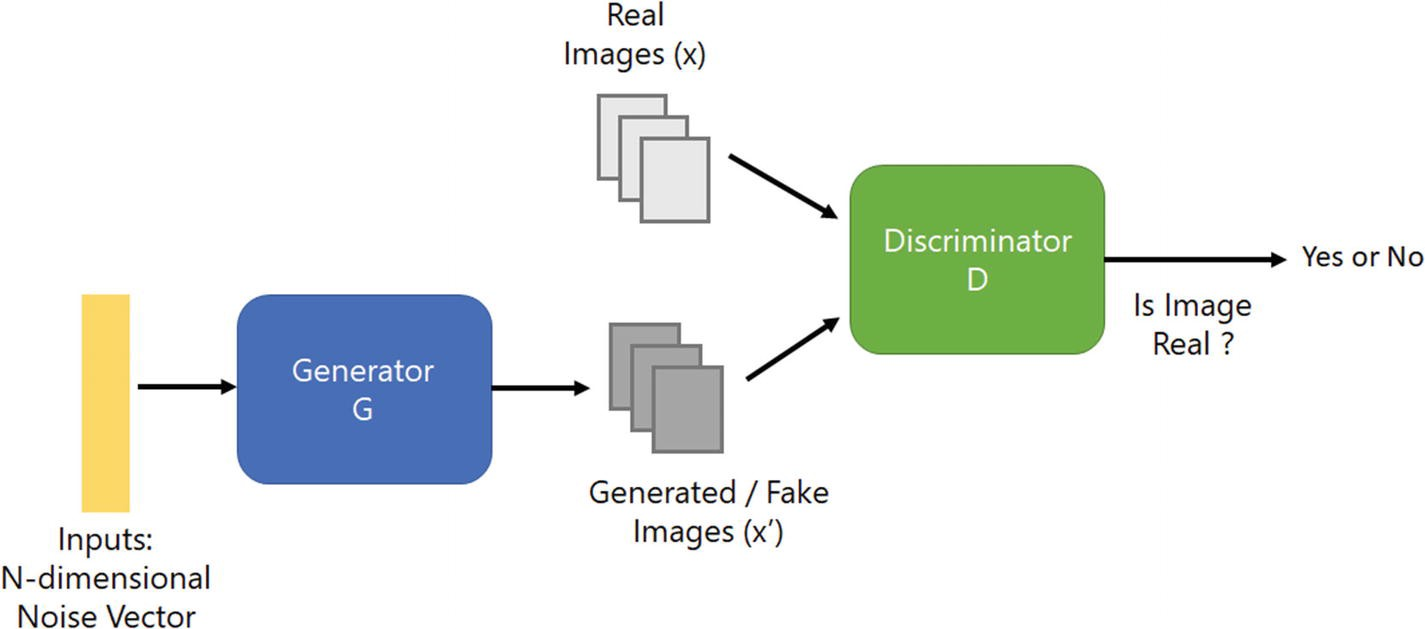

### What are GANs
Generative Adversarial Networks belong to the set of generative models. It means that they are able to produce / to generate (we’ll see how) new content.<br><br>
Generative Adversarial Networks (GANs) can be broken down into three parts:
- <b>Generative</b>: To learn a generative model, which describes how data is generated in terms of a probabilistic model.<br>
- <b>Adversarial</b>: The training of a model is done in an adversarial setting.<br>
- <b>Networks</b>: Use deep neural networks as the artificial intelligence (AI) algorithms for training purpose.<br>

### What is Generator and Discriminator?

##### Generator - An artist
##### Discriminator - An art critic
The <b>Generator</b> generates fake samples of data(be it an image, audio, etc.) and tries to fool the <b>Discriminator</b>. The <b>Discriminator</b>, on the other hand, tries to distinguish between the real and fake samples. The <b>Generator and the Discriminator are both Neural Networks and they both run in competition with each other in the training phase</b>. The steps are repeated several times and in this, the Generator and Discriminator get better and better in their respective jobs after each repetition.

In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2D, Dropout, Flatten, Conv2DTranspose

selu activation funtion: Scaled Exponential Linear Unit : learn faster and better than other activation functions, even if they are combined with batch normalization.

In [ ]:
NUM_FEATURES = 100
def make_generator():
    generator = tf.keras.Sequential([
        Dense(7*7*256, input_shape = [NUM_FEATURES]),
        BatchNormalization(),
        Reshape([7,7,256]),
#         BatchNormalization(),
        #upsampling
        Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', activation='selu'),
        BatchNormalization(),
        #upsampling
        Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', activation='selu'),
        BatchNormalization(),

        Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh')
    ])
    
    return generator

generator = make_generator()

 ### Untrained generator to create an image.
 
 Create a seed or a vector of random noise. We'll  create a normally distibuted noised image.

In [ ]:
noise = tf.random.normal(shape=[1, NUM_FEATURES]) # 1 because we need 1 generated image
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Once we'll train out DCGAN we will see this randomly generated noise to be some object.

## Building the Discriminator Network for DCGAN
NOTE: The discriminator is a CNN-based image classifier.

In [ ]:
#Fashion MNIST shape = (28,28,1)
def make_discriminator():
    discriminator = tf.keras.Sequential([
        Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(128, (5,5), strides=(2,2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(256, (5,5), strides=(1,1), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation='sigmoid') #binary classificaion
    ])
    
    return discriminator

discriminator = make_discriminator()

Using untrained discriminator to classify the generated images as real or fake.

In [ ]:
decision = discriminator(generated_image)
print(decision)

## Compiling the DCGAN